# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [28]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [29]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

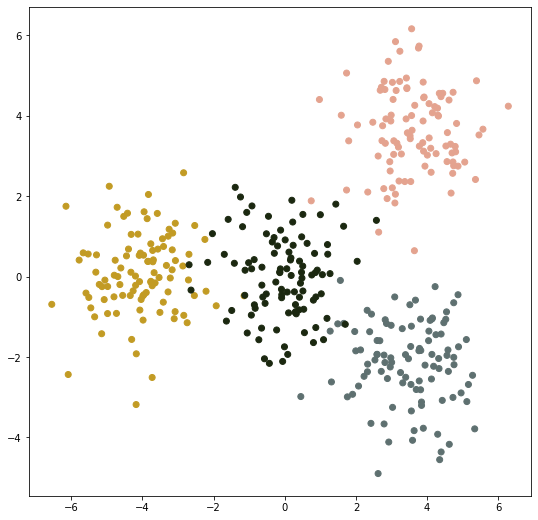

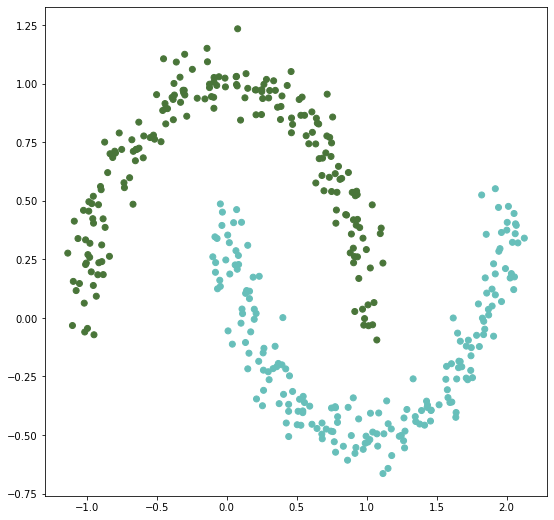

In [442]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [465]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None

        
    def random_centroids(self, X):
        max_value = np.amax(X)
        min_value = np.amin(X)
        centr = (max_value - min_value)*np.random.random((self.n_clusters, X.shape[1])) 
        return centr 
        
    
    def sample_centroids(self, X):
        ind = random.choices(np.arange(self.n_clusters), k = self.n_clusters)
        centr = X[ind]
        return centr
    
    def kpp_centroids(self, X):
        centr = np.zeros((self.n_clusters, X.shape[1]))
        centr[0] = X[np.random.choice(np.arange(self.n_clusters))]
        weigh = self.distances(centr[0], X)**2
        l = np.sum(weigh, axis=0) 
        weigh = weigh/l
        for i in range(1, self.n_clusters):
            centr[i] = X[random.choices(np.arange(X.shape[0]), weights=weigh, k=1)]
            weigh = self.distances(centr[i], X)**2
            l = np.sum(weigh, axis=0) 
            weigh = weigh/l
        return centr
            
            
        
    def distances(self, a, b):
        d = np.sum((a-b)**2, axis=1) 
        d = np.sqrt(d)
        return d
       
    
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        if self.init == "random":
            centr = self.random_centroids(X) #временный массив центроид
        elif self.init == "sample":
            centr = self.sample_centroids(X)
        elif self.init == "k-means++":
            centr = self.kpp_centroids(X)
        else:
            raise ValueError("Wrong init")
        
        classes = np.zeros(X.shape[0]) #здесь храним принадлежность к классам
        new_classes = np.zeros(X.shape[0])
        
        
        for _ in range(self.max_iter):
            for i, item in enumerate(X):
                d = self.distances(item, centr) #считаем расстояние до каждой центроиды
                min_center = np.argmin(d) #возвращаем индекс минимизирующей центроиды
                new_classes[i] = min_center
                                                         
            if np.array_equal(classes, new_classes): #если ничего не меняется, алгоритм все
                self.centroids = centr
                break

            else:
                classes = new_classes #перемещаем центроиды в средние точки 
                for i in range(self.n_clusters):
                    isclass = i == classes
                    if np.any(isclass):
                        centr[i] = np.mean(X[isclass], axis=0)
                    else: #может быть такое, что точка попала куда-то, где к ней ничего не согли отнести
                        centr[i] = X[np.random.choice(np.arange(self.n_clusters))]
        
        
    
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        labels = np.array([])
        for item in X:
            d = self.distances(item, self.centroids)
            x = np.argmin(d)
            labels = np.append(labels, x) #возвращаем индекс минимизирующей центроиды
        #print(labels)
        return labels.astype(np.int)
            

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

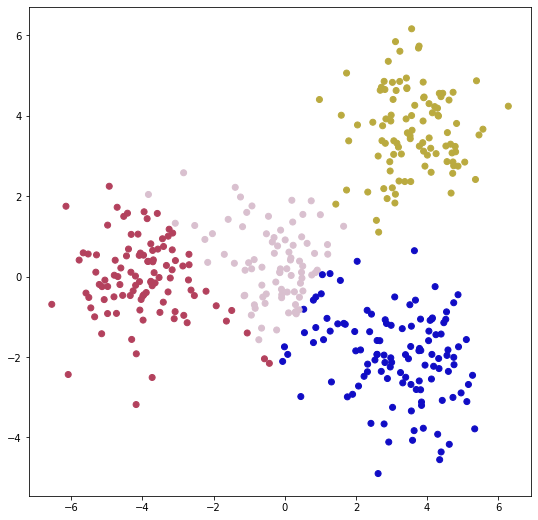

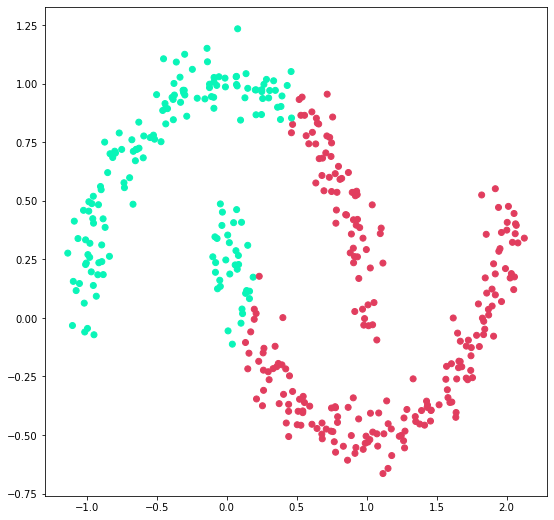

In [483]:
kmeans = KMeans(n_clusters=4, init="k-means++")
kmeans.fit(X_1)

labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="k-means++")

kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)


### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [629]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        
        tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        neigh = tree.query_radius(X, self.eps)
        classes = -np.ones(X.shape[0]) #-1 отвечает за шум, сначала сделаем все шумом
        visited = [False]*X.shape[0]
        cls = 0
        for i in range(X.shape[0]):
            if visited[i]: #если мы уже заходили в вершину
                continue
            visited[i] = True
            
            cur_neigh = neigh[i].tolist() #пройдемся по соседям вершины
            
            if len(cur_neigh)  < self.min_samples: #если у вершины слишком мало соседей, она шум
                continue
            
            classes[i] = cls
            
            
            while cur_neigh:
                u = cur_neigh.pop()
                if visited[u]: #если уже были здесь, уходим
                    continue
                visited[u] = True
                classes[u] = cls
                
                if neigh[u].shape[0] >= self.min_samples: #если соседей достаточно, чтобы добавить
                    cur_neigh.extend(neigh[u].tolist()) 
                if classes[u] == -1:
                    classes[u] = cls
                    
            cls += 1
        classes[classes == -1] = cls #надо сделать шум последним номером, а то визуализация ругается, когда его нет
        return classes.astype(int)
                    
            
        

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

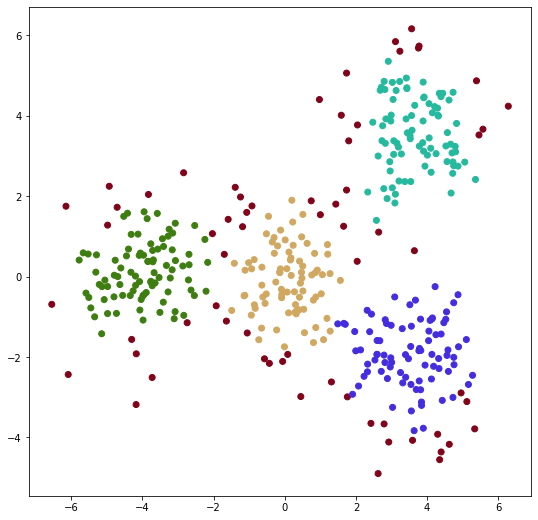

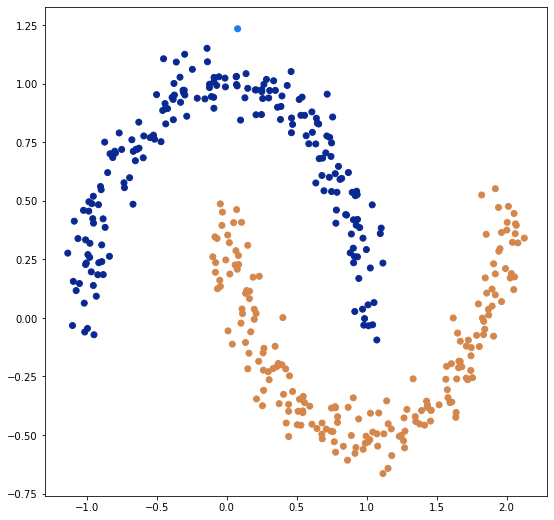

In [630]:
dbscan = DBScan(min_samples=9, eps=0.67)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(min_samples=5, eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [ ]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n_clusters = n_clusters
        self.linkage = linkage
    
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        classes = np.arange(X.shape[0]) #сначала каждая точка - свой класс
        
        
        

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [ ]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [686]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    normalized_image = cv2.normalize(img_rgb, None, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return normalized_image

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    img = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image_bgr)

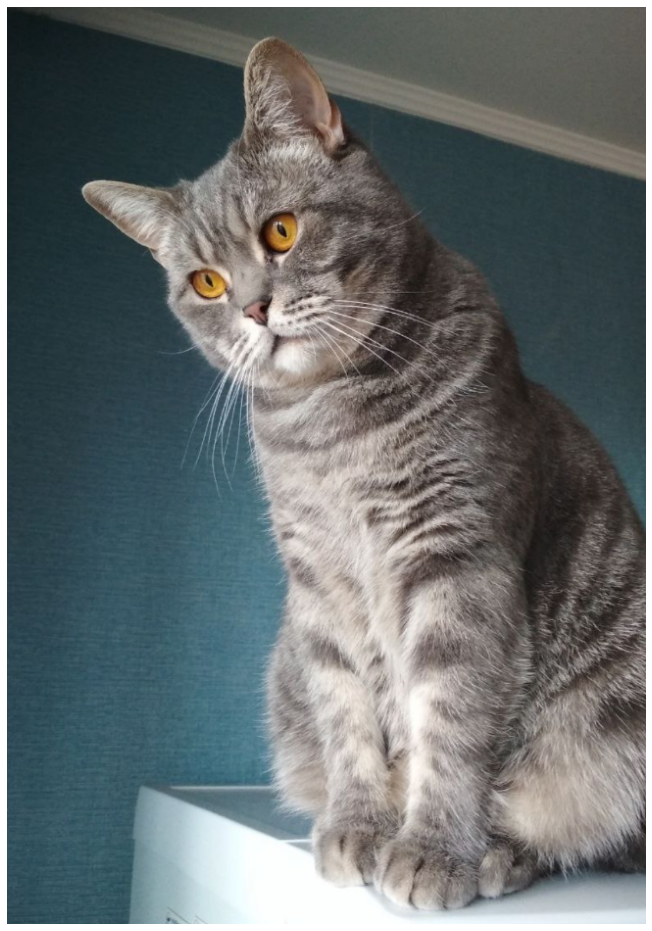

In [781]:
show_image(read_image("./image.png"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [776]:
def clusterize_image(image, col=4, **kwargs):
    X = image.reshape(-1, image.shape[-1]).copy()
    kmeans = KMeans(n_clusters=col, init="random")
    kmeans.fit(X) 
    
    clusters = kmeans.predict(X)
    elem = np.unique(clusters)
    cluster_colors = kmeans.centroids
    recolored =  X
    
    for i, color in enumerate(elem):        
        recolored[clusters == color] = cluster_colors[i]
    
    clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters) # Very slow (:
    return recolored

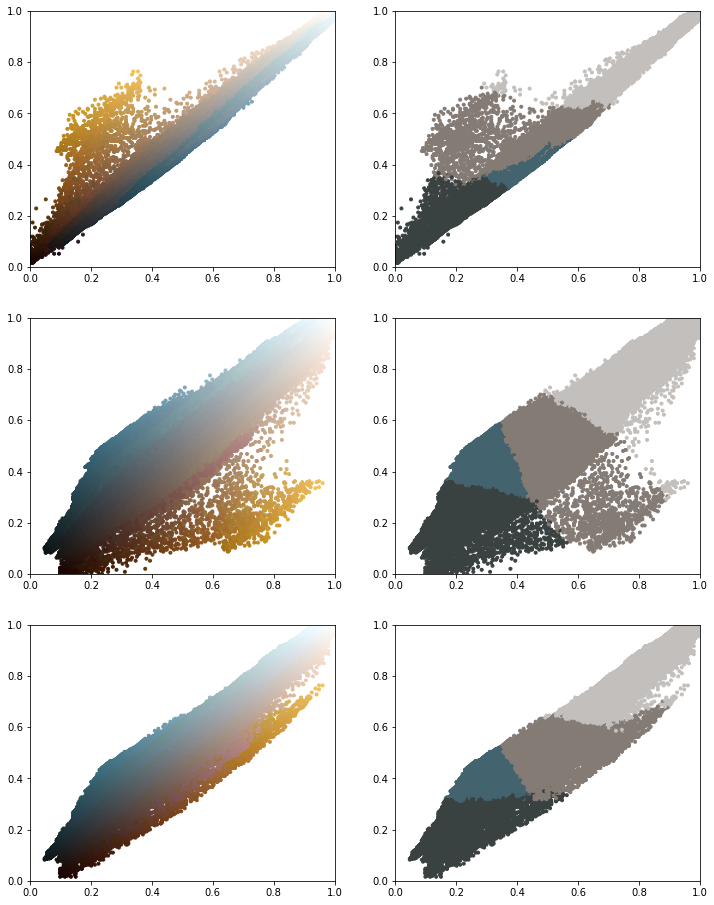

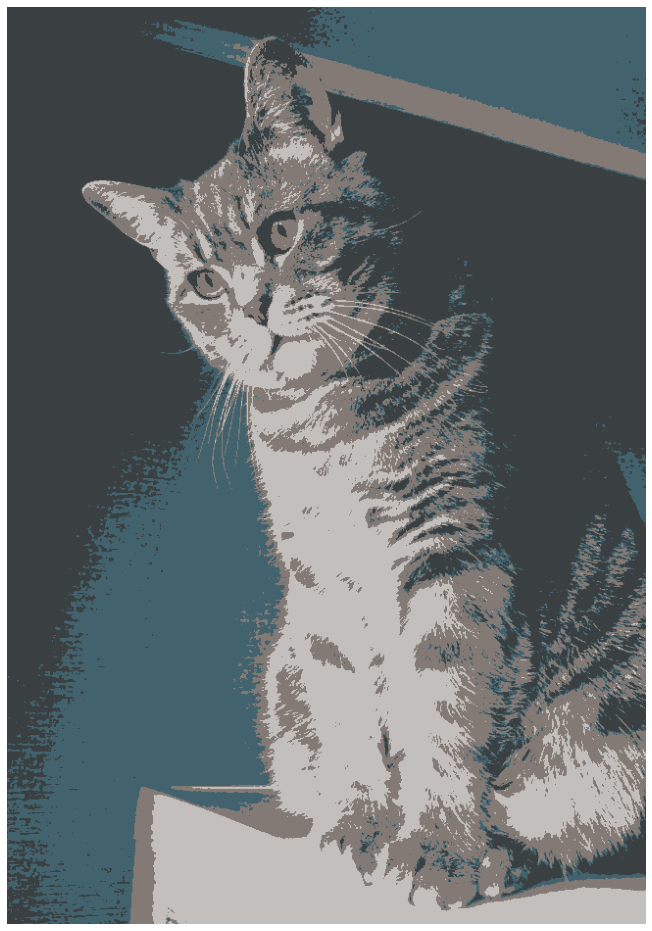

In [777]:
image = read_image("./image.png")
recolored = clusterize_image(image)
recolored = recolored.reshape(image.shape)
show_image(recolored)
save_image(result, "result.png")